## Preparation

Welcome to the Vectice Insurance Claim Predictions notebook!

Through this notebook, we will be illustrating how to log the following information into Vectice using the Vectice Python library:
- Dataset versions
- Model versions
- Runs and lineage

### Install Vectice

In [1]:
#Install Vectice Python library 
# In this tutorial we will do code versioning using github, we also support gitlab
# and bitbucket: !pip install -q "vectice[github, gitlab, bitbucket]"
#!pip install -q vectice[github]
!pip install vectice[github]==0.24.1 --extra-index-url=https://test.pypi.org/simple/

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
#Verify if Vectice python library was installed
!pip3 show -q vectice

## Getting the data from S3

Here, the our data is stored in Amazon S3. We should install the following S3 packages in order to be able to get it.

In [3]:
## S3 file system package
!pip3 install --q s3fs
## Upgrade pandas
!pip3 install --q --upgrade pandas

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

We are going to load data stored in Amazon S3, that is provided by Vectice for this tutorial.

- If you're using Sagemaker studio with access to your data on S3 or if your data is public, you can read it by using pd.read_csv(The S3 URI of your file)
- If you're using Sagemaker studio without access to your data on S3, you should authenticate to be able to retrieve your data from S3. For more information, check the [documentation](https://doc.vectice.com/)

In [4]:
!pip3 install -q matplotlib
!pip3 install -q seaborn
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('s3://vectice-examples/Tutorial/insurance.csv')
df = df.rename(columns={"sex": "gender", "bmi": "health_score", "smoker": "pre_condition"})
# removing the column Region as it is not of our best interest
df = df.drop('region', axis = 1)

# Run head to make sure the data was loaded properly
df.head()

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

,age,gender,health_score,children,pre_condition,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice Python library.

In [5]:
#Import the Vectice library
from vectice import Vectice
from vectice.models import JobType
from vectice.entity.model import ModelType
import logging
logging.basicConfig(level=logging.INFO)

# Specify the API endpoint for Vectice.
os.environ['VECTICE_API_ENDPOINT']= "demo.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "API TOKENS" tab in your workspace
# Copy and paste your API key here
os.environ['VECTICE_API_TOKEN'] = "5lLr5J9KN.2Zk6QqWDp7zaPeYwOno45lLr5J9KNBMv8bydjR13gVAXmJEG2V"

# Next, you need to specify the tutorial project where you will run this notebook using a 
# "Project Token". You can find the "Project Token" under the "Settings" tab of your project.

# Copy and paste your Project Token here
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
vectice = Vectice(project_token="OEKWQ03ahEgPG4m9z5mA", autocode= True)

INFO:vectice.auth:Vectice: Refreshing token... 
INFO:vectice.auth:Success!
INFO:vectice.auth:Vectice: Validating project token... 
INFO:vectice.auth:The entered token is OK, and allows you to work on the 'Insurance Claim Charges Prediction' Project, part of the 'Insurance' Workspace


### Exploratory Data Analysis

Let's see how is the data distribution and understand the impact for each feature!

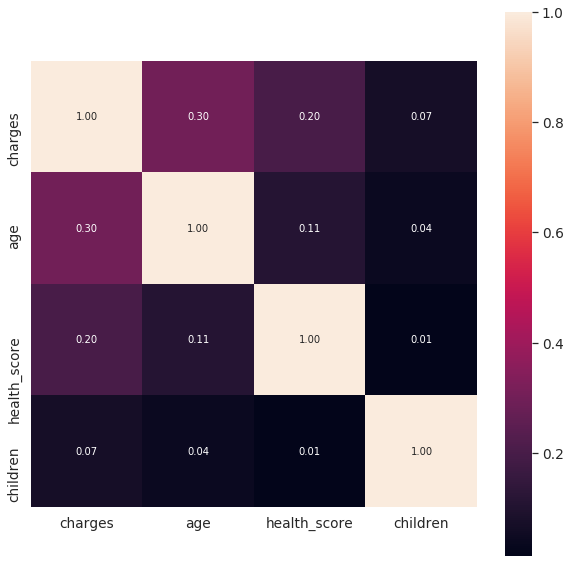

<Figure size 432x288 with 0 Axes>

In [6]:
# Correlation

plt.figure(figsize = (10, 10))
corrmat = df.corr()
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'charges')['charges'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
plt.savefig("Correlation_Heatmap.png")

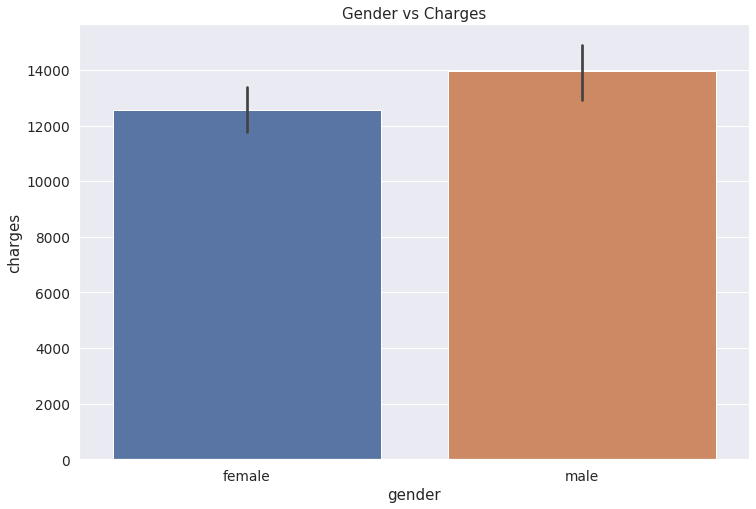

In [7]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'gender', y = 'charges', data = df)
plt.title("Gender vs Charges")
plt.savefig("Gender.png")

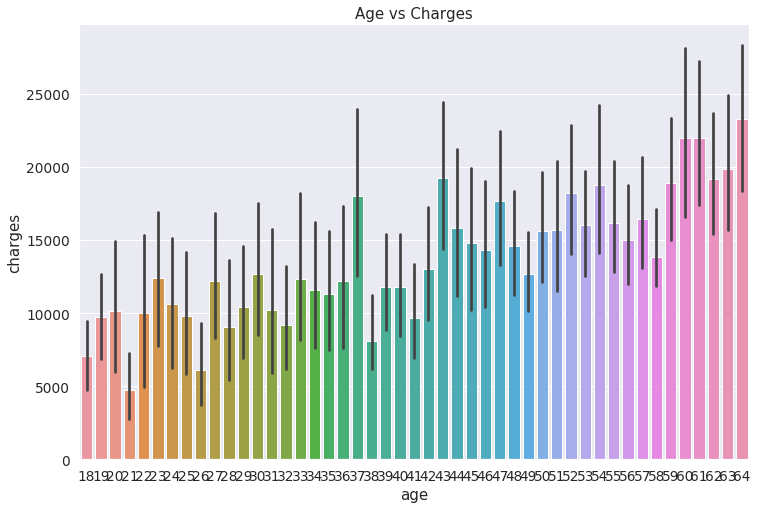

In [8]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'age', y = 'charges', data = df)
plt.title("Age vs Charges")
plt.savefig("Age.png")

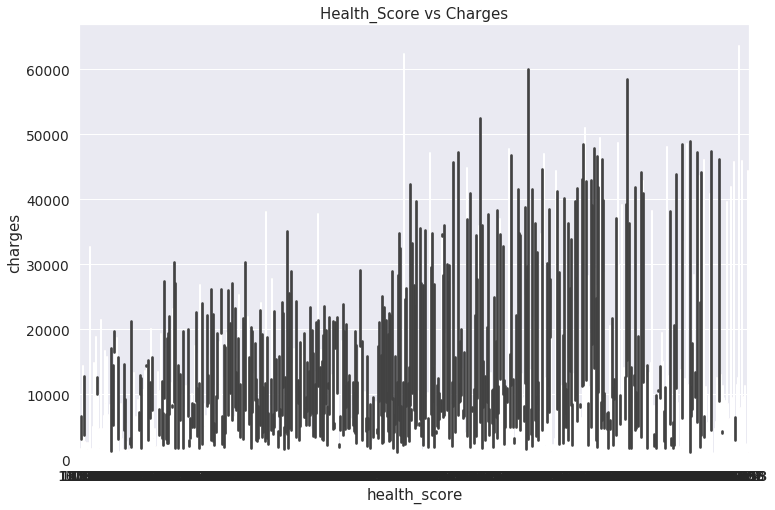

In [9]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'health_score', y = 'charges', data = df)
plt.title("Health_Score vs Charges")
plt.savefig("HealthScore.png")

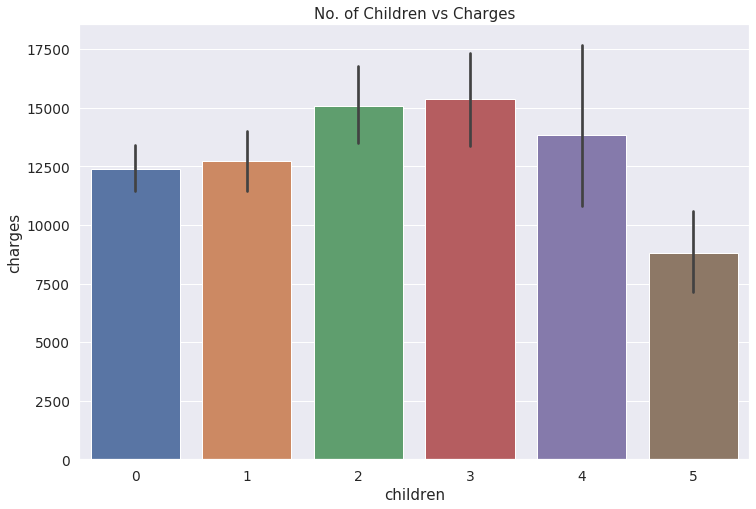

In [10]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'children', y = 'charges', data = df)
plt.title("No. of Children vs Charges")
plt.savefig("Children.png")

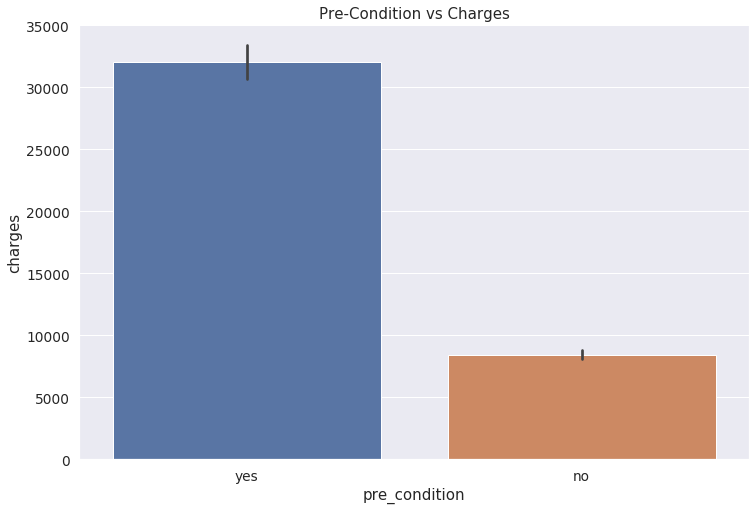

In [11]:
# Plotting Box Plots for --
plt.figure(figsize = (12, 8))
sns.barplot(x = 'pre_condition', y = 'charges', data = df)
plt.title("Pre-Condition vs Charges")
plt.savefig("PreCondition.png")

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['pre_condition'] = le.fit_transform(df['pre_condition'])
df.head()

,age,gender,health_score,children,pre_condition,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice Python library.

In [7]:
!pip install -q scikit-learn
import string
from math import sqrt
# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression


/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


### Split dataset into training and testing

Let's split the dataset into train and test sets and save them in S3.
(The S3 code has been commented out as the data has already been generated). For this section, we will re-use some datasets that have been already created to illustrate dataset versioning.


We can get the list of the datasets existing in our project by calling **vectice.list_datasets()**

In [8]:
vectice.list_datasets().list

[DatasetOutput(id=41, pattern='*', isPatternBase=False, createdDate='2022-02-14T08:52:54.755Z', updatedDate='2022-02-14T08:53:20.791Z', deletedDate=None, connectionId=9, createdByUserId=1, projectId=22, version=2, name='Insurance Claim Charges Prediction - v1', project=None, description='Initialize the dataset to be pulled from S3 environment')]

In [9]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the Vectice Python library will create a new dataset version the first time you execute this code.

input_ds_version = vectice.create_dataset_version().with_parent_name("cleaned_insurance_claim_data")

# Because we are using Colab in this tutorial example we are going to declare a reference to the code
# manually. This will be added as a reference to the run we are going to create next.
# If you are using your local environment with GIT installed or JupyterLab etc... the code
# tracking is automated.
input_code = Vectice.create_code_version_with_github_uri("https://github.com/vectice/vectice-examples",
                                         "/Insurance_Claim_Sagemaker.ipynb") 

# Each execution for a given job is called a run. When creating a run you need to specify:
# 1) a job name (mandatory): Job names are unique for each project
# 2) a job type (optional)
# 3) a run name (optional): The run names are unique for each job
# Job names, job types and run names are useful to group and search runs in the Vectice UI.
# For this run, we will use the job name "80/20 Split", the job type "PREPARATION" and the run name "data-prep"
# You can have multiple runs with the same job name
vectice.create_run(job_name = "80/20 Split", job_type = JobType.PREPARATION, run_name = 'data')
with vectice.start_run(inputs=[input_ds_version,input_code]) as run:

# We will use an 80/20 split to prepare the data
    test_size = 0.2

# We will set the random seed so we always generate the same split.
    random_state = 42
    train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in S3, 
# because we already generated the data for you.
# The key provided for this tutorial give you read access only to S3.
# We left the code below for convenience, in case you want to use your own credentials and S3 bucket.
# train.to_csv (r's3://vectice-examples/Tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r's3://vectice-examples/Tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
    X = df.drop("charges", axis=1).values
    y = df["charges"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Let's create new training and testing datasets.
# We will use the existing dataset created by Albert, so that we can append new 
# dataset versions to it.

    train_ds_version = vectice.create_dataset_version().with_parent_name("train_cleaned_insurance_claim_data")
    test_ds_version = vectice.create_dataset_version().with_parent_name("test_cleaned_insurance_claim_data")

# Attach the output datasets to the run.
    run.add_outputs(outputs=[train_ds_version,test_ds_version])

# We can preview one of our generated outputs to make sure that everything was executed properly.
    X_train


NameError: name 'input_code' is not defined

## Modeling

### Linear regression model

First, we will do a basic Linear Regression and observe the baseline accuracy metrics.

In [81]:
# Each execution for a given job is called a run, for LR we will only do one run.
# Setting a job's name is mandatory when starting a run 
# and is useful to group and search runs in the Vectice UI.
from sklearn.preprocessing import StandardScaler

# creating a standard scaler
sc = StandardScaler()

# feeding independents sets into the standard scaler
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
# Linear regression model training
vectice.create_run(job_name = "LR-Model", job_type = JobType.TRAINING)     #, run_name = "LR7 model")
with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:

    lr_rg = LinearRegression()
    lr_rg.fit(X_train, y_train)
    lr_pred = lr_rg.predict(X_test)
    score = lr_rg.score(X_train,y_train)

# Evaluate Metrics
    MAE = mean_absolute_error(lr_pred, y_test)
    RMSE = sqrt(mean_squared_error(lr_pred, y_test))

    print("Root Mean Squared Error: ", RMSE)
    print("Mean Absolute Error: ", MAE)
    print("Model Score: ", score.round(2))

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
## Here we use with_user_version() to create a new model version. You can provide a version name for your model version.
# An error will be thrown if the given user version already exists and if you don't provide a version name,
# the version name will be "Version"+"the version number".
    model_version = vectice.create_model_version().with_parent_name("Regressor").with_algorithm("Linear Regression").with_type(ModelType.REGRESSION).with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_user_version()
    run.add_outputs(outputs=[model_version])


Root Mean Squared Error:  5830.756384113757
Mean Absolute Error:  4217.267958976172
Model Score:  0.74


We can update a model's type or description by using **vectice.update_model()**

In [51]:
vectice.update_model(parent_name="Regressor", model_type=ModelType.REGRESSION, description="Model description")

INFO:Vectice:Model: 'Regressor' has been updated


### Decision tree model

In this section let's use the decision tree algorithm and compare the accuracy to the logistic regression algorithm. We will try different values for the tree_depth. We will log the model parameters and metrics in Vectice.

Root Mean Squared Error: 4564.574975458218
Mean Absolute Error: 2865.882825198861
Model Score:  0.87


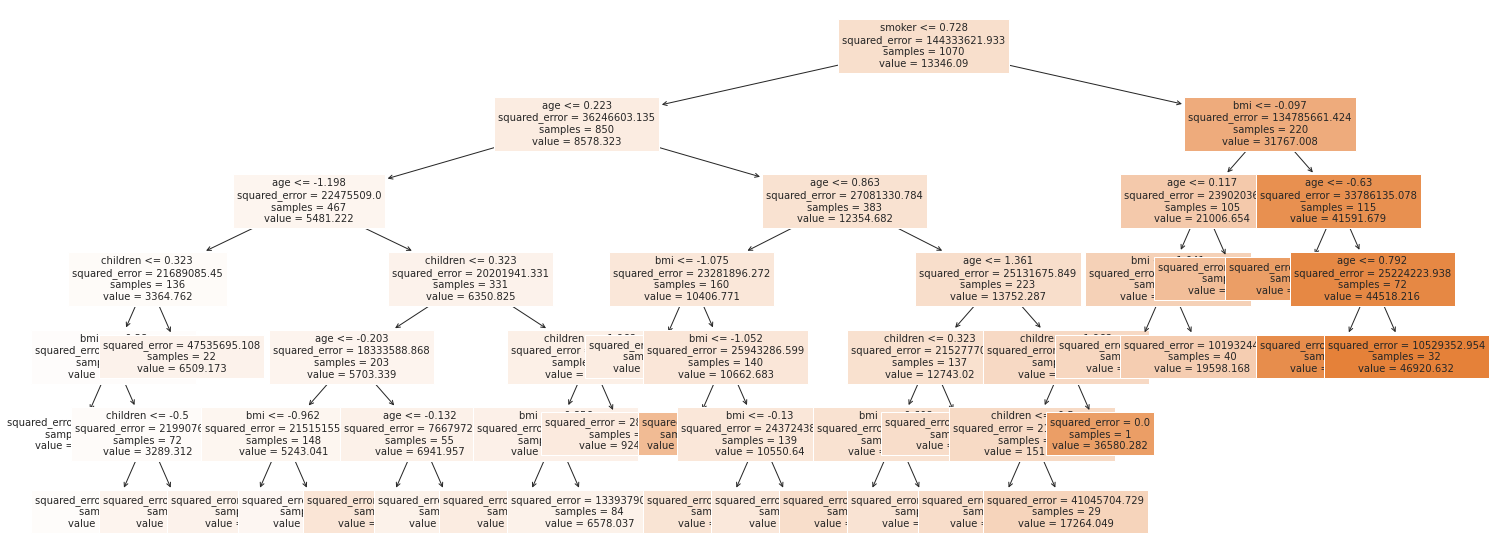

In [80]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
# The model versions you created will show up in the Vectice UI as new versions 
# of the "Regressor" Model. You can easily compare them from there.
tree_depth = 4

vectice.create_run(job_name = "DT-Model", job_type = JobType.TRAINING)

with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:

    dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
    dtr.fit(X_train,y_train)
    dtr_pred = dtr.predict(X_test) 
    data_feature_names = ['age','sex', 'bmi', 'children', 'smoker']
    
# Visualize the Decision Tree Model
    plt.figure(figsize=(25, 10))
    plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)
    plt.savefig("DecisionTree_4.png")
  ## We can attach the decision tree plot to the model version by using .with_attachments([Attachments])
    MAE = mean_absolute_error(dtr_pred, y_test)
    RMSE = sqrt(mean_squared_error(dtr_pred, y_test))
    score = dtr.score(X_train,y_train)
    print("Root Mean Squared Error:", RMSE)
    print("Mean Absolute Error:", MAE)
    print("Model Score: ", score.round(2))
# Here we use with_user_version() to create a new model version. You can provide a version name 
# for your model version. An error will be thrown if the given user
# version already exists and if you don't provide a version name, the version name will be 
# "Version"+"the version number".
    model_version = vectice.create_model_version().with_user_version().with_parent_name("Regressor").with_algorithm("Decision Tree").with_type(ModelType.REGRESSION).with_property("Tree Depth",str(tree_depth)).with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_attachments(["DecisionTree_6.png"])
    run.add_outputs(outputs=[model_version])

### Random forest model

Let's use the Random Forest Regression and do some hyper-parameter tuning on it.

In [79]:
from sklearn.ensemble import RandomForestRegressor

vectice.create_run(job_name = "RF-Model", job_type = JobType.TRAINING)
with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    regressor.fit(X_train, y_train)
    # Predicting a new result
    regressor_pred = regressor.predict(X_test)
    score = regressor.score(X_train,y_train)
    
    MAE = mean_absolute_error(regressor_pred, y_test)
    RMSE = sqrt(mean_squared_error(regressor_pred, y_test))
    print("Root Mean Squared Error:", RMSE)
    print("Mean Absolute Error:", MAE)
    print("Model Score: ", score.round(2))

# Here's an alternative version to declare metrics
    metrics = [("RMSE",RMSE),("MAE",MAE)]
    model_version = vectice.create_model_version().with_parent_name("Regressor").with_algorithm("Random Forest").with_type(ModelType.REGRESSION).with_property("nb_trees",str(10)).with_metrics(metrics).with_user_version()
    run.add_outputs(outputs=[model_version])


Root Mean Squared Error: 4870.44115717617
Mean Absolute Error: 2609.2662855223884
Model Score:  0.96


We can get the list of the models existing in the project by calling **vectice.list_models()**

In [58]:
vectice.list_models().list

[ModelOutput(createdDate='2022-02-11T15:30:41.880Z', updatedDate='2022-02-11T19:54:29.045Z', version=2, id=2964, authorId=554, workspaceId=1051, projectId=3565, repository=None, deletedDate=None, name='Regressor', type='REGRESSION', description='Model description')]

You can also get all the model versions you created in previous runs, for offline analysis and understanding in more details what's driving the models performance.

In [61]:
vectice.list_model_versions_dataframe(model_id = 2964)

,createdDate,name,versionNumber,status,algorithmName,isStarred,MAE,RMSE,Tree Depth,nb_trees
0,2022-02-11T19:55:31.544Z,Version 4,4,EXPERIMENTATION,Decision Tree,False,2865.882825198861,4564.574975458218,6,NaN
1,2022-02-11T19:54:29.045Z,Version 3,3,EXPERIMENTATION,Decision Tree,False,2875.4378688651627,4604.055836532279,10,NaN
2,2022-02-11T15:31:47.107Z,Version 2,2,EXPERIMENTATION,Random Forest,False,2609.2662855223884,4870.44115717617,NaN,10
3,2022-02-11T15:30:41.915Z,Version 1,1,EXPERIMENTATION,Linear Regression,False,4217.267958976169,5830.756384113756,NaN,NaN


We can see that the Random Forest Regressor model gives the lowest error and should be the preferred approach despite the complexity of the algorithm. Let's get the list of features' importance to discuss which variables are influencing the model the most.

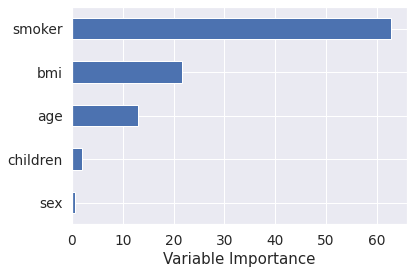

In [56]:
columns = ['age','gender', 'health_score', 'children', 'pre_condition']

importance = pd.DataFrame({'Importance': regressor.feature_importances_ * 100}, index=columns)
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="b")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None
plt.savefig("ImpVariables.png")

Thank you and congratulations! You have succesfully completed the notebook part of the tutorial.

In this notebooks we have illustrated how you can capture your experiments, hyper-parameters, dataset versions and metrics using Vectice Python library. 
You can now leverage Vectice UI for analysis, documentation and to engage a business conversation around the findings.

Vectice enables you to:
1. Make your experiments more reproducible.
2. Track the data and code that is used for each experiment and model versions.
3. Document your projects' progress and collaborate with your team in Vectice's UI.
4. Discover previous work and reuse your team knowledge for new projects.

We are constantly improving the Vectice Python library and the Vectice application. Let us know what improvements you would like to see in the solution and what your favorite features are after completing this tutorial. 

Feel free to explore more and come up with your own ideas on how to best start leveraging Vectice!
